# Analysis COSI Dataset 

In [1]:
import numpy as np
import os as os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm as CM
import random
import pandas as pd
color = sn.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time
import missingno as msno
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from summarizer import Summarizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Reading data 

In [2]:
##############
#READING DATA#
##############
mydir_read = 'C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\'

df_Q1 = pd.read_excel(mydir_read + 'COSI_LABELS_Final.xlsx', sheet_name=0)
df_Q2 = pd.read_excel(mydir_read + 'COSI_LABELS_Final.xlsx', sheet_name=1)
df_Q3 = pd.read_excel(mydir_read + 'COSI_LABELS_Final.xlsx', sheet_name=2)

df_code_loc = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\my_amplifon_centers.xlsx')

# France Map

In [3]:
# ENGINEERING FOR FRANCE MAP
# file with geometric shape of France's departments (without overseas)
dpt = "C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\departements.geojson"
df_dpt = gpd.read_file(dpt)

# file with geometric shape of France's regions (with overseas)
reg_avec_om = "C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\regions-avec-outre-mer.geojson"
df_reg_avec_om = gpd.read_file(reg_avec_om)

In [4]:
## separate regions' geodataframe with metropolitan regions on one side and overseas regions on the other

# sort region code in ascending order
df_reg_avec_om = df_reg_avec_om.sort_values(by="code") 

# for overseas regions (5 regions-departements) keep first 5 lines 
df_rom = df_reg_avec_om[:5] 
df_rom = df_rom.reset_index(drop=True)

# for metropolitan France (13 regions)
df_reg = df_reg_avec_om[5:]  
df_reg = df_reg.reset_index(drop=True)

# choose 5 anchor points
anchor_pt = pd.DataFrame([[51, -7.223655], [49, -7.223655], [47, -7.223655], [45, -7.223655], [43, -7.223655]], columns=["lat", "lon"])

# find the centroïd of each region's multipolygon 
df_rom["center"] = df_rom['geometry'].centroid  

C:\Users\mcampi\AppData\Local\Temp\ipykernel_29352\2712605821.py:18: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [5]:
# calculate the distance in latitude and longitude between the centroïd and its corresponding anchor point 

dist_list =[]

for i, row in df_rom.iterrows():
    x_dist = anchor_pt.loc[i, "lon"] - (row["center"].x)  # différence entre longitude
    y_dist = anchor_pt.loc[i, "lat"] - (row["center"].y)  # différence entre latitude
    dist_list.append((x_dist, y_dist))  # ajouter à la liste

In [6]:
# keep each line in different geodataframe
guadeloupe = gpd.GeoDataFrame(df_rom.iloc[0,]).T
martinique = gpd.GeoDataFrame(df_rom.iloc[1,]).T
guyane = gpd.GeoDataFrame(df_rom.iloc[2,]).T
reunion = gpd.GeoDataFrame(df_rom.iloc[3,]).T
mayotte = gpd.GeoDataFrame(df_rom.iloc[4,]).T

# resize Guyane which is bigger than other overseas departments
guyane["geometry"] = guyane["geometry"].scale(0.15,0.15)

# shift coordinates of each overseas regions by the distance find earlier
guadeloupe["geometry"] = guadeloupe["geometry"].translate(dist_list[0][0], dist_list[0][1])
martinique["geometry"] = martinique["geometry"].translate(dist_list[1][0], dist_list[1][1])
guyane["geometry"] = guyane["geometry"].translate(dist_list[2][0], dist_list[2][1])
reunion["geometry"] = reunion["geometry"].translate(dist_list[3][0], dist_list[3][1])
mayotte["geometry"] = mayotte["geometry"].translate(dist_list[4][0], dist_list[4][1])

# concatenate new coordinates in a new geodataframe
rom = pd.concat([guadeloupe, martinique, guyane, reunion, mayotte], axis=0)

# resize again the regions 
rom["geometry"] = rom["geometry"].scale(3,3)

# delete "center" columns
del rom["center"]

# concate metropolitan regions with overseas regions
gdf_reg_avec_om = pd.concat([df_reg, rom], axis=0).reset_index(drop=True)

c:\Users\mcampi\Anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).



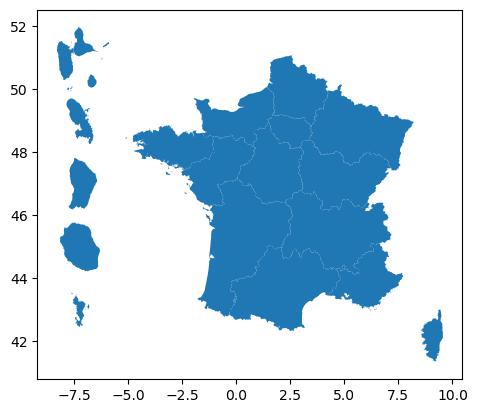

In [7]:
# plot results !  -- REGIONS
gdf_reg_avec_om.plot()
plt.show()

In [8]:
# change overseas region code by their department code
code_reg_dpt = {"01": "971",
                "02": "972",
                "03": "973",
                "04": "974",
                "06": "976"}

dom = rom.replace({"code": code_reg_dpt})
dom

code         nom                                           geometry
0  971  Guadeloupe  MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50...
1  972  Martinique  MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48...
2  973      Guyane  MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47...
3  974  La Réunion  MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44...
4  976     Mayotte  MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43...

In [9]:
# concatenate metropolitan regions and overseas region 
gdf_dpt_avec_om = pd.concat([df_dpt, dom], axis=0).reset_index(drop=True)

c:\Users\mcampi\Anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).



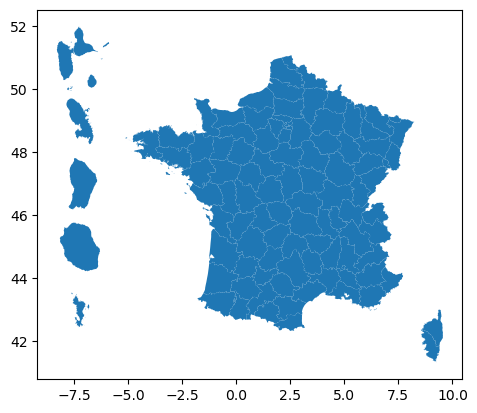

In [10]:
# plot  -- DEPARTMENTS
gdf_dpt_avec_om.plot()
plt.show()

In [11]:
geo_loc= df_code_loc.iloc[:, [3, 4]]
geo_loc = gpd.GeoDataFrame(geo_loc)
geometry = [Point(lon, lat) for lon, lat in zip(geo_loc['Longitude'], geo_loc['Latitude'])]
geo_loc = gpd.GeoDataFrame(geo_loc, geometry=geometry)

df_code_loc['Department'] = gpd.sjoin(geo_loc, gdf_dpt_avec_om,  how='left', op='within').iloc[:, [5]]

c:\Users\mcampi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_29352\1948003415.py:6: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




In [18]:
#file_path = mydir_read + 'gdf_dpt_avec_om.geojson'
#gdf_dpt_avec_om.to_file(file_path, driver='GeoJSON')

#excel_filename = mydir_read + 'df_code_loc.xlsx'
#df_code_loc.to_excel(excel_filename, index=False)

In [ ]:
#df_code_loc = pd.read_excel(excel_filename)   USE THIS ONE AT THE END
#gdf_dpt_avec_om = gpd.read_file(mydir_read + 'gdf_dpt_avec_om.geojson')   USE THIS ONE AT THE END

In [95]:
shop_counts_df = df_code_loc['Department'].value_counts().reset_index()
shop_counts_df.columns = ['nom', 'Count']

map_france_shop = gdf_dpt_avec_om

map_france_shop = map_france_shop.merge(shop_counts_df, on='nom', how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


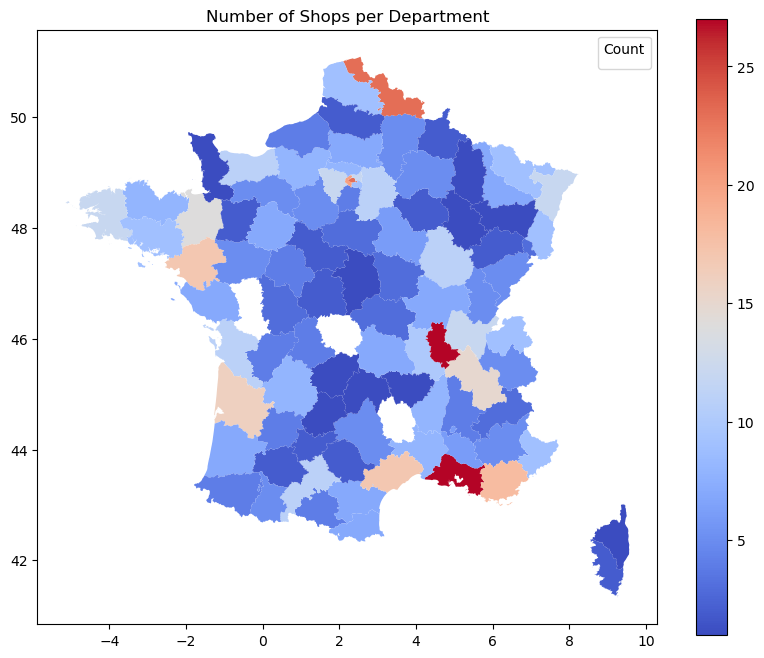

In [96]:
# Plot the GeoDataFrame with color based on the count
ax = map_france_shop.plot(column='Count', legend=True, figsize=(10, 8), cmap='coolwarm') #viridis plasma coolwarm cividis rainbow inferno

# Add a title and adjust legend settings if needed
ax.set_title('Number of Shops per Department')
ax.legend(title='Count')

plt.show()

In [97]:
# Mapping the Deparments to the shop code in the data

df_code_loc.rename(columns={'Centre': 'SHOP_CODE'}, inplace=True)

df_q1_dp = df_Q1.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')
df_q2_dp = df_Q2.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')
df_q3_dp = df_Q3.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')

# Adding question number

df_q1_dp['Question'] = 1
df_q2_dp['Question'] = 2
df_q3_dp['Question'] = 3

#Concatenate the data
df_Qs = pd.concat([df_q1_dp, df_q2_dp, df_q3_dp], ignore_index=True)


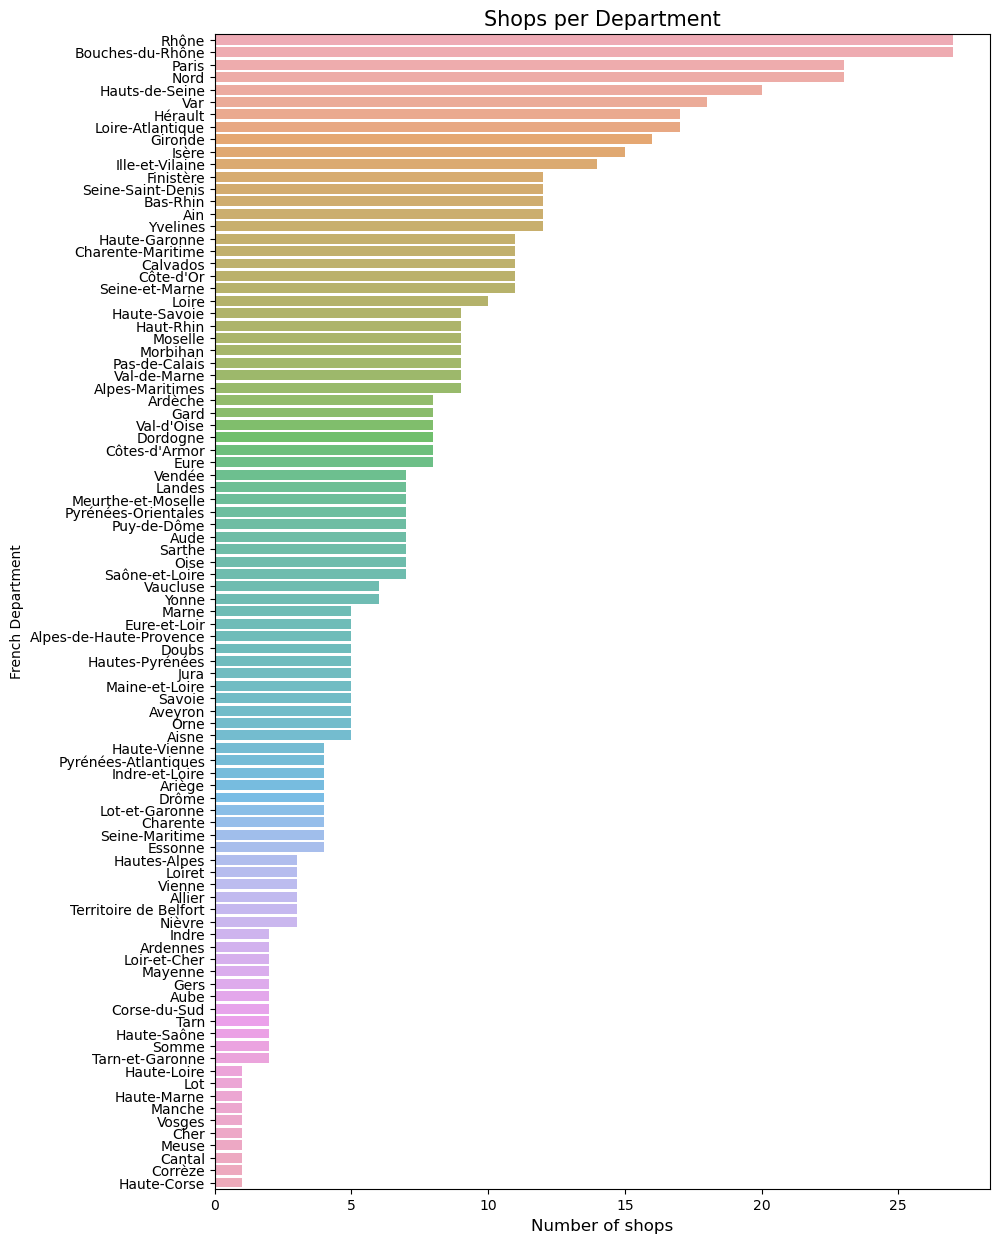

In [453]:
shop_per_dep = df_code_loc['Department'].value_counts()
plt.figure(figsize=(10,15))
sn.barplot(y=shop_per_dep.index, x=shop_per_dep.values, alpha=0.8)
plt.xlabel('Number of shops', fontsize=12)
plt.ylabel('French Department', fontsize=10)
plt.title("Shops per Department", fontsize=15)
plt.show()

# Intial Plots Analysis

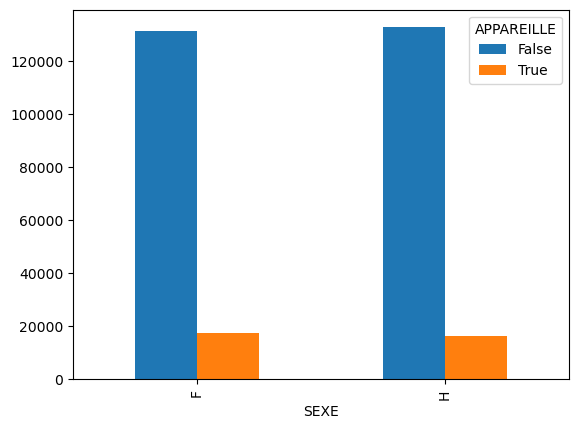

In [448]:
df_Qs_counts = df_Qs.drop_duplicates(subset='CUSTOMER_CODE', keep='first').groupby(['SEXE', 'APPAREILLE']).size().reset_index(name='Count')

pivot_dfqS_counts = df_Qs_counts.pivot(index='SEXE', columns='APPAREILLE', values='Count')
pivot_dfqS_counts.plot(kind='bar', stacked=False)
plt.show()

In [449]:
df_Qs_counts

SEXE  APPAREILLE   Count
0    F       False  131326
1    F        True   17503
2    H       False  132881
3    H        True   16550

In [452]:
df_Qs_counts['Count'].sum()

298260

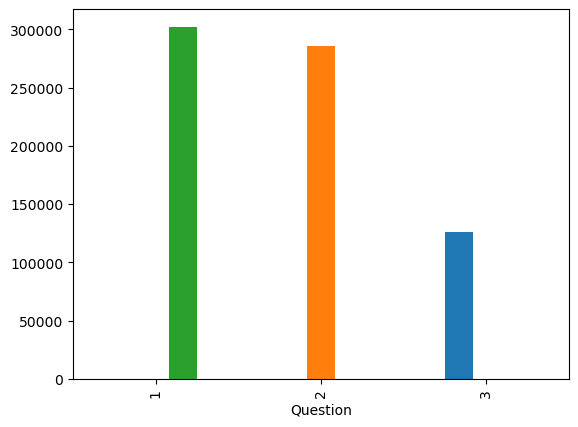

In [465]:
n_answers = df_Qs.groupby(['Question']).size().reset_index(name='Count')

pivot_df_answers = n_answers.pivot(index='Question', columns='Count', values='Count')
pivot_df_answers.plot(kind='bar', stacked=False, legend=False)
plt.show()

In [ ]:
# add count of people per question and create a new dataset where you put the labels for Q1 and Q2 and Q3 per row hence customer_code, age, sex, label_Q1, label_Q2, label_Q3 and then  we decide what to do - if we consider the 3 questions or not?

In [479]:
def plot_label_counts(ax, df, title):
    df_labels_count = df.groupby(['Label']).size().reset_index(name='Count')

    bars = ax.bar(df_labels_count['Label'], df_labels_count['Count'], 
                  width=0.8, edgecolor='black',
                  color=plt.cm.rainbow(df_labels_count.index / len(df_labels_count)))
    ax.set_xticks(range(len(df_labels_count['Label'])))
    ax.set_xticklabels(df_labels_count['Label'], rotation=45, ha='right')

    # Add count annotations on each bar
    for i, count in enumerate(df_labels_count['Count']):
        ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

    ax.set_title(title)



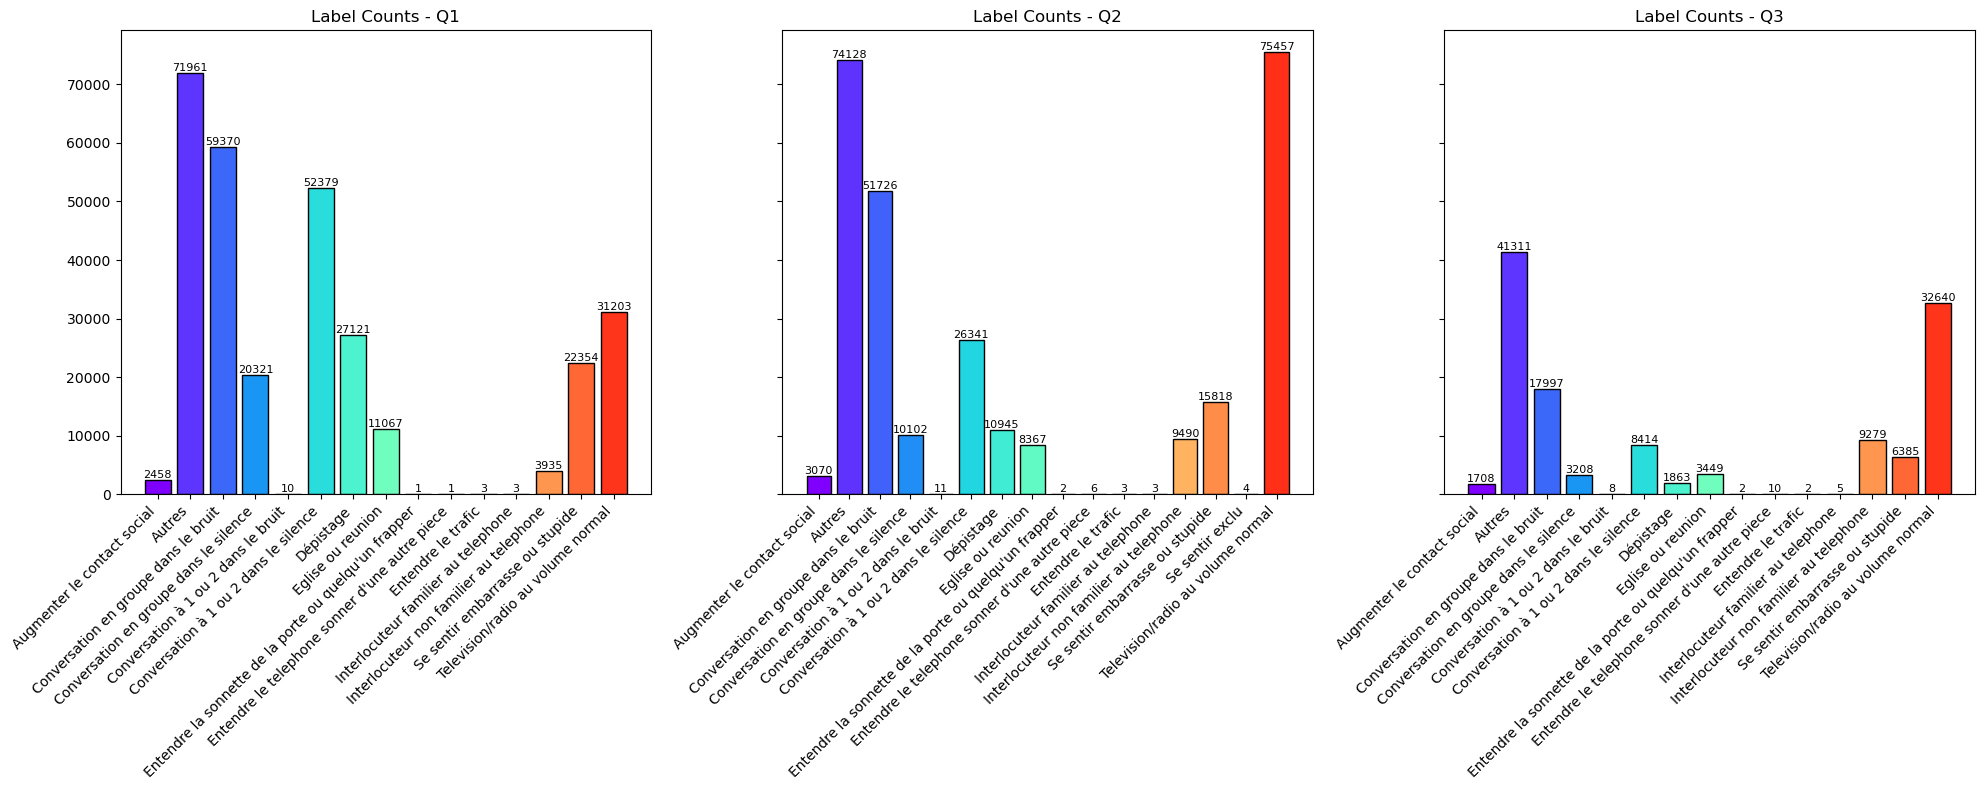

In [489]:
# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Plot each DataFrame on a separate subplot
plot_label_counts(axs[0], df_Q1, 'Label Counts - Q1')
plot_label_counts(axs[1], df_Q2, 'Label Counts - Q2')
plot_label_counts(axs[2], df_Q3, 'Label Counts - Q3')

plt.tight_layout()
plt.show()

In [486]:
def plot_percentage_bars(ax, df, title):
    df_labels_percentage = df.groupby(['Label']).size() / len(df) * 100
    df_labels_percentage = df_labels_percentage.reset_index(name='Percentage')

    bars = ax.bar(df_labels_percentage['Label'], df_labels_percentage['Percentage'], 
                   width=0.8, edgecolor='black',
                   color=plt.cm.rainbow(df_labels_percentage.index / len(df_labels_percentage)))
    ax.set_xticks(range(len(df_labels_percentage['Label'])))
    ax.set_xticklabels(df_labels_percentage['Label'], rotation=45, ha='right')

    # Add percentage annotations on each bar
    for i, percentage in enumerate(df_labels_percentage['Percentage']):
        ax.text(i, percentage + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

    ax.set_title(title)



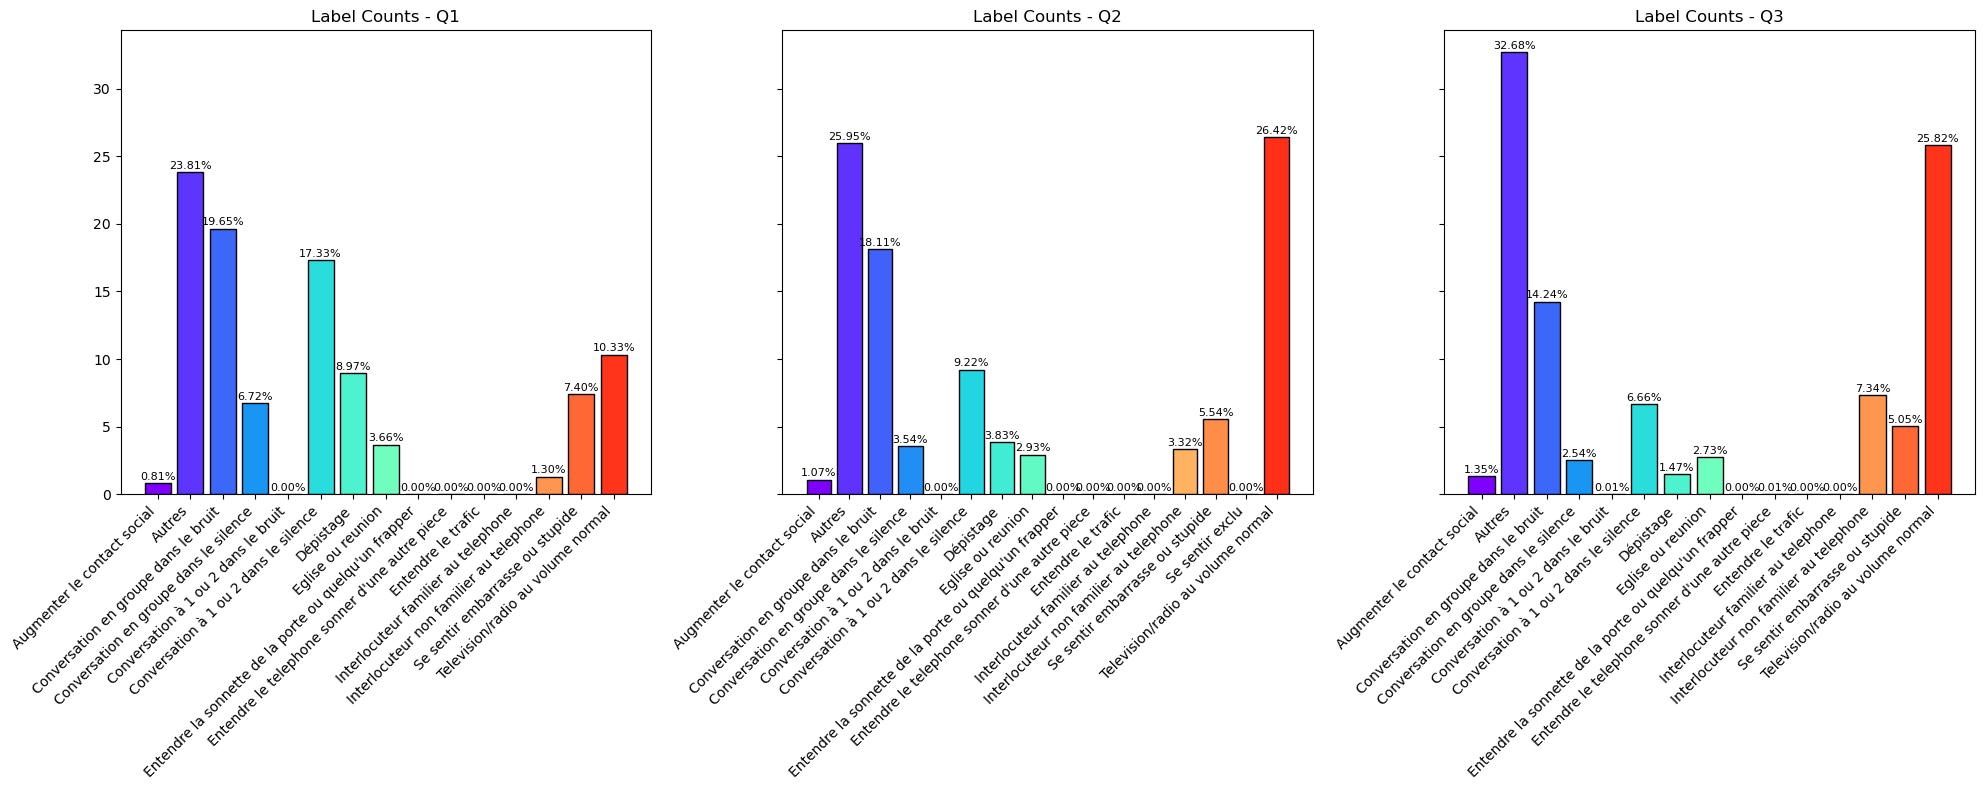

In [488]:
# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Plot each DataFrame on a separate subplot
plot_percentage_bars(axs[0], df_Q1, 'Label Counts - Q1')
plot_percentage_bars(axs[1], df_Q2, 'Label Counts - Q2')
plot_percentage_bars(axs[2], df_Q3, 'Label Counts - Q3')

plt.tight_layout()
plt.show()

In [579]:
labels_dfQ =df_Qs['Label'].unique()
labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  # Generate labels for the bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # Adjust the bin edges as needed


In [581]:
def plot_age_distribution(df, label_to_filter, bins):
    # Filter DataFrame based on the given label
    filtered_df = df[df['Label'] == label_to_filter].drop_duplicates(subset='CUSTOMER_CODE', keep='first')

    # Create a new column 'AgeGroup' based on the bins
    filtered_df['AgeGroup'] = pd.cut(filtered_df['AGE'], bins=bins, labels=labels_age, right=False)

    # Group by 'AgeGroup' and count occurrences
    age_distribution = filtered_df.groupby('AgeGroup').size().reset_index(name='Count')

    # Plot the bar chart
    age_distribution.plot(kind='bar', x='AgeGroup', y='Count', legend=False)
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.title(f'Age Distribution of {label_to_filter}')
    plt.show()


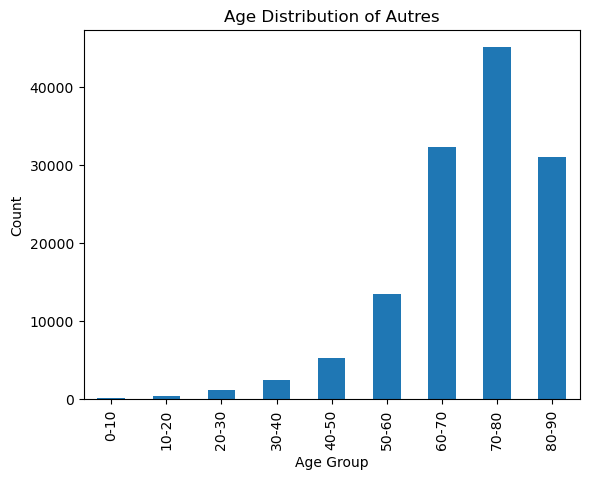

In [582]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[0]

plot_age_distribution(df_Qs, label_to_filter, bins)

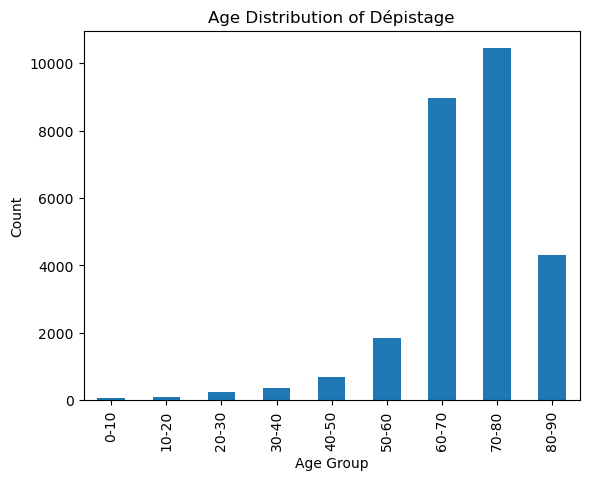

In [569]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[1]

plot_age_distribution(df_Qs, label_to_filter, bins)

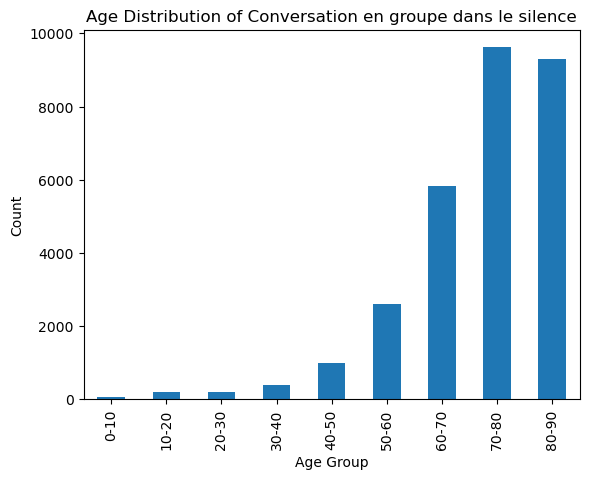

In [572]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[3]

plot_age_distribution(df_Qs, label_to_filter, bins)

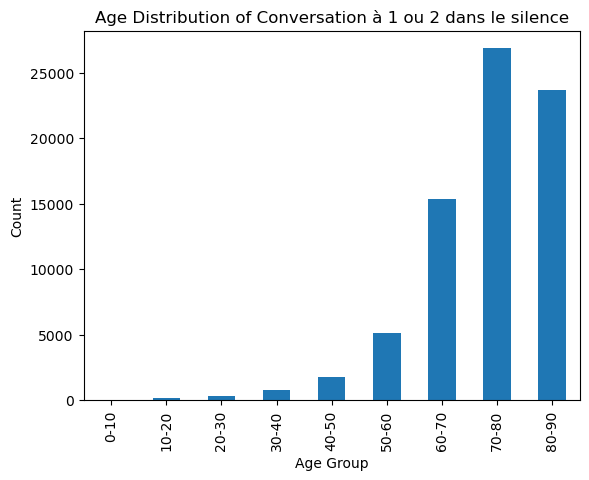

In [573]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[4]

plot_age_distribution(df_Qs, label_to_filter, bins)

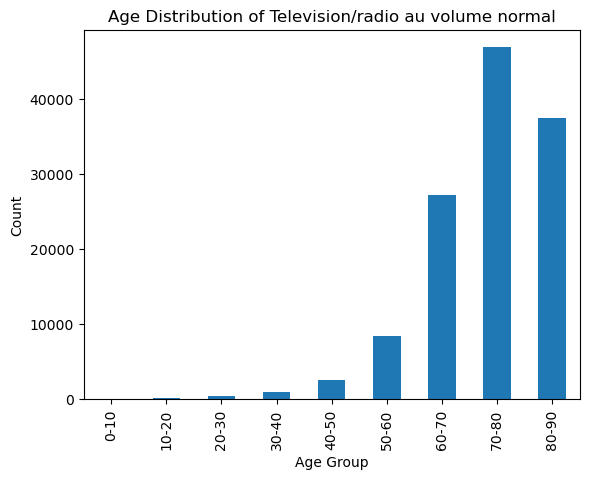

In [574]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[5]

plot_age_distribution(df_Qs, label_to_filter, bins)

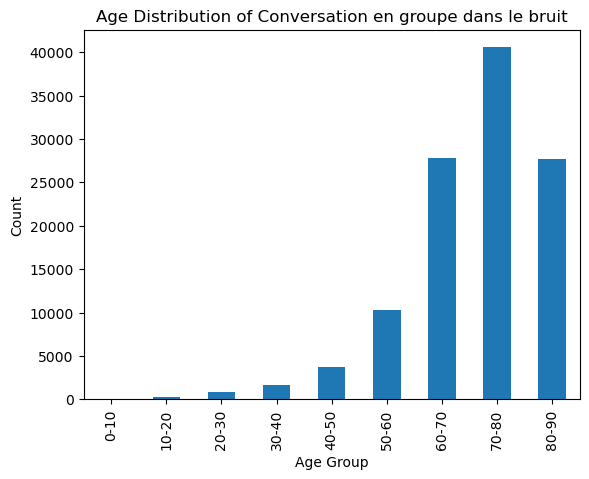

In [575]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[6]

plot_age_distribution(df_Qs, label_to_filter, bins)

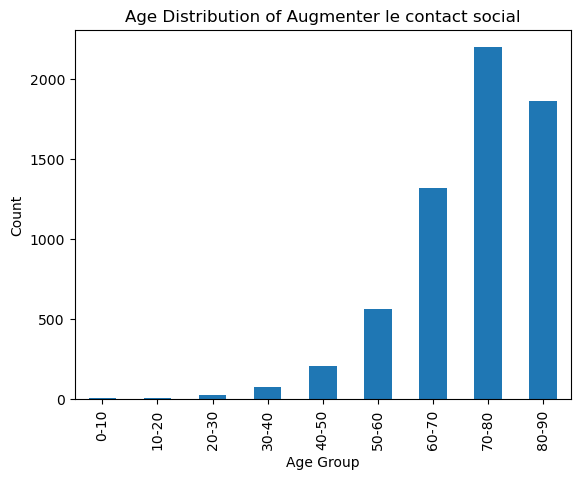

In [576]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[7]

plot_age_distribution(df_Qs, label_to_filter, bins)

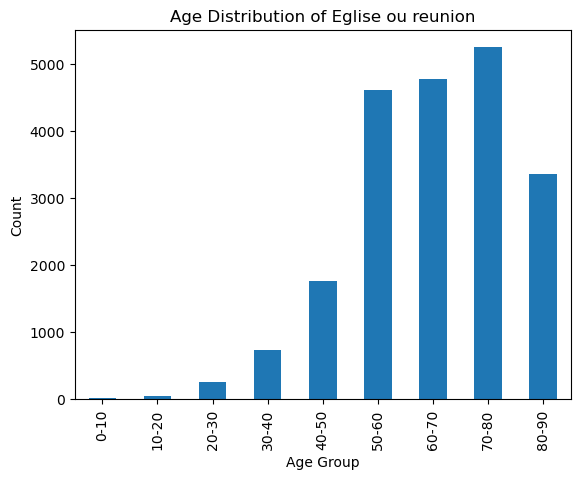

In [577]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[8]

plot_age_distribution(df_Qs, label_to_filter, bins)

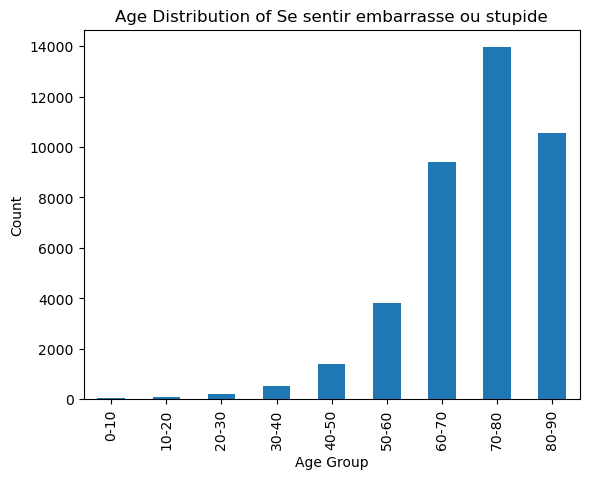

In [583]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[9]

plot_age_distribution(df_Qs, label_to_filter, bins)

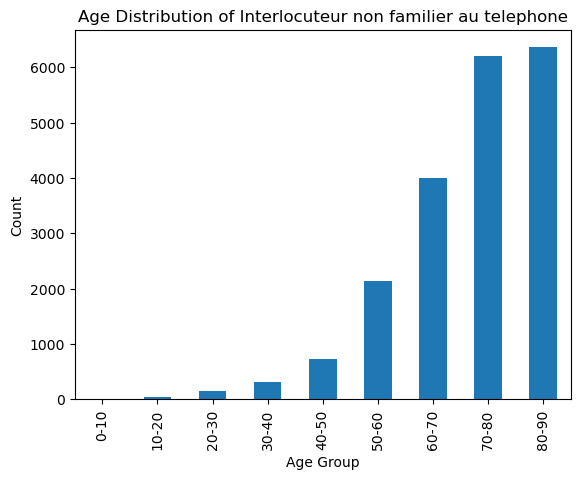

In [585]:
# Insert a number according to the one above
label_to_filter = labels_dfQ[10]

plot_age_distribution(df_Qs, label_to_filter, bins)

# Spatial Plots Analysis

In [175]:
q_grouped_sexdp = df_Qs.groupby(['SEXE'])
unique_groups = list(q_grouped_sexdp.groups.keys())
split_q_sexdp = [q_grouped_sexdp.get_group(group) for group in unique_groups]

In [179]:
#CHECK
split_q_sexdp[0]['CUSTOMER_CODE']

1              204
2              329
5             1322
9             1880
11            1913
            ...   
714242    36902150
714248    21706197
714249    23402256
714251    49406800
714252    58607192
Name: CUSTOMER_CODE, Length: 356517, dtype: object

In [180]:
len(split_q_sexdp[0]['CUSTOMER_CODE'].unique())

148829

In [187]:
split_q_sexdp[0].drop_duplicates(subset='CUSTOMER_CODE', keep='first')

CUSTOMER_CODE SEXE   AGE  SHOP_CODE  \
1                204    F   NaN        371   
2                329    F   NaN        708   
5               1322    F   NaN        137   
9               1880    F   NaN        716   
11              1913    F   NaN        326   
...              ...  ...   ...        ...   
712777      09103646    F  91.0         91   
712863      15801311    F  91.0        158   
713001      22805537    F  91.0        228   
713868      11702818    F  95.0        117   
713914      21600815    F  95.0         83   

                                              OPEN_ANSWER  APPAREILLE  \
1       je souhaite faire un bilan auditif suite à vot...       False   
2                          mieux comprendre dans le bruit       False   
5          ameliorer la perception de la voix de mon mari       False   
9                      je souhaite connaitre mon audition       False   
11                     faire un dépistage de mon audition       False   
...                                                   ...         ...   
712777  Que les apperils tiennent mieux sur les oreilles.       False   
712863     JE SOUHAITE MIEUX COMPRENDRE DANS LE BROUHAHA.       False   
713001                                    ne pas s'isoler       False   
713868  Mieux comprendre une personne de la famille qu...        True   
713914  améliorer la compréhension de la parole en env...        True   

                                        Label       Department  Question  
1                                   Dépistage          Moselle         1  
2         Conversation à 1 ou 2 dans le bruit           Manche         1  
5       Conversation à 1 ou 2 dans le silence        Haut-Rhin         1  
9                                   Dépistage            Rhône         1  
11                                  Dépistage  Ille-et-Vilaine         1  
...                                       ...              ...       ...  
712777                                 Autres            Aisne         3  
712863   Conversation en groupe dans le bruit      Haute-Loire         3  
713001            Augmenter le contact social          Gironde         3  
713868  Conversation à 1 ou 2 dans le silence    Haute-Garonne         3  
713914   Conversation en groupe dans le bruit            Paris         3  

[148829 rows x 9 columns]

In [188]:
split_q_sexdp = [split_q_sexdp[i].drop_duplicates(subset='CUSTOMER_CODE', keep='first') for i in range(0,len(split_q_sexdp))]

In [ ]:
#now it s okay since duplicates coming from several questions are removed

In [189]:
pp_counts_df_f = split_q_sexdp[0]['Department'].value_counts().reset_index()
pp_counts_df_f.columns = ['nom', 'Count']

pp_counts_df_m = split_q_sexdp[1]['Department'].value_counts().reset_index()
pp_counts_df_m.columns = ['nom', 'Count']

In [190]:
map_france_f = gdf_dpt_avec_om
map_france_f = map_france_f.merge(pp_counts_df_f, on='nom', how='inner')

map_france_m = gdf_dpt_avec_om
map_france_m = map_france_m.merge(pp_counts_df_m, on='nom', how='inner')

In [191]:
# Define custom segmented color maps for male (blue shades) and female (pink shades)
cmap_male = LinearSegmentedColormap.from_list('cmap_male', ['#B2DDFF', '#0072B2'])
cmap_female = LinearSegmentedColormap.from_list('cmap_female', ['#FFB2C8', '#E30066'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


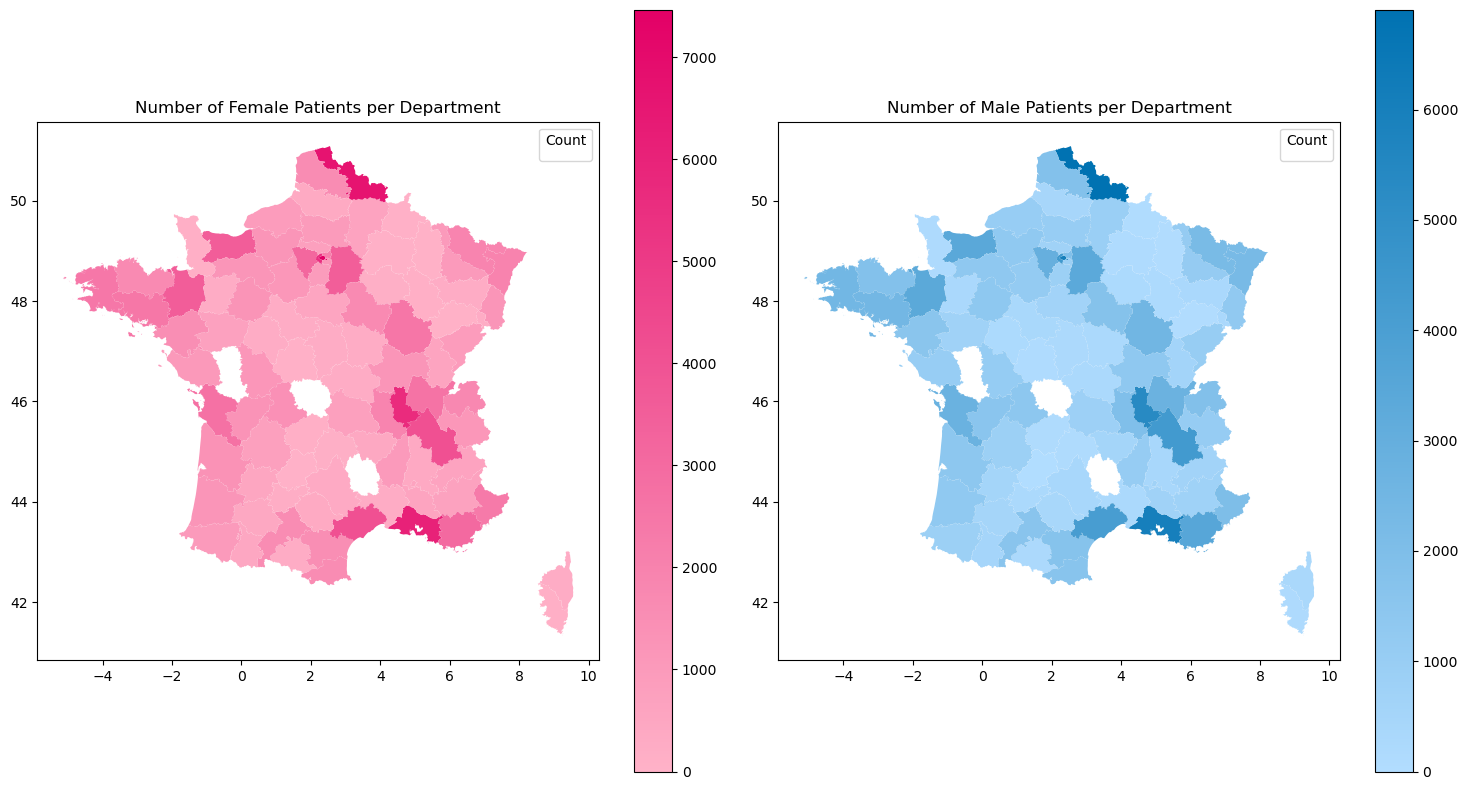

In [192]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the GeoDataFrame with color based on the count in the first subplot
map_france_f.plot(column='Count', legend=True, ax=axs[0], cmap=cmap_female, vmin=0, vmax=np.max(map_france_f["Count"]))
axs[0].set_title('Number of Female Patients per Department')
axs[0].legend(title='Count')

# Plot the GeoDataFrame with color based on the count in the second subplot
map_france_m.plot(column='Count', legend=True, ax=axs[1], cmap=cmap_male, vmin=0, vmax=np.max(map_france_m["Count"]))
axs[1].set_title('Number of Male Patients per Department')
axs[1].legend(title='Count')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [125]:
df_dp_filt = df_Qs[df_Qs['Department'] != 'NA']
df_dp_filt = df_Qs[df_Qs['AGE'] != 'NA']

# Calculate the average age within each Department
average_age_dp = df_dp_filt.groupby('Department')['AGE'].mean().reset_index()
average_age_dp.columns = ['nom', 'Average Age']

map_france_av_age = gdf_dpt_avec_om
map_france_av_age = map_france_av_age.merge(average_age_dp, on='nom', how='inner')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


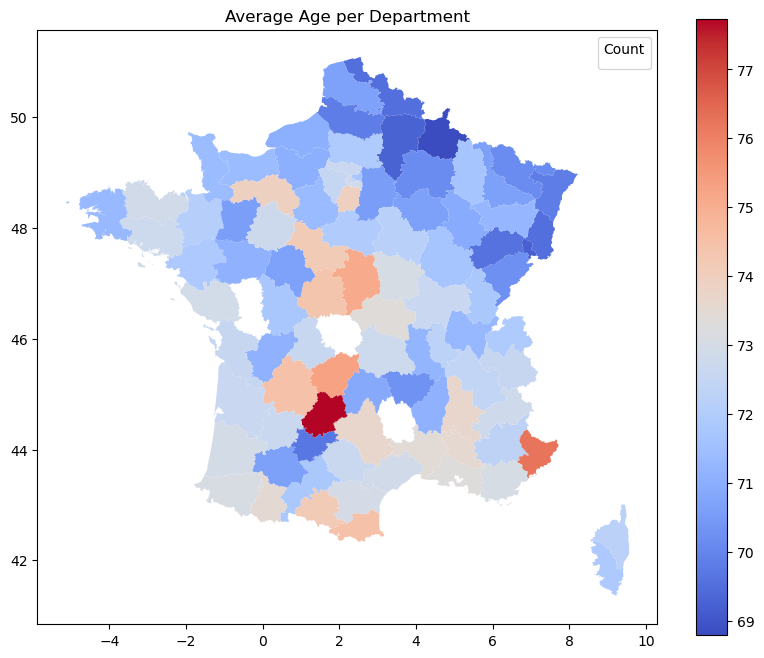

In [126]:
# Plot the GeoDataFrame with color based on the count
ax = map_france_av_age.plot(column='Average Age', legend=True, figsize=(10, 8), cmap='coolwarm') #viridis plasma coolwarm cividis rainbow inferno

# Add a title and adjust legend settings if needed
ax.set_title('Average Age per Department')
ax.legend(title='Count')

plt.show()

In [193]:
grouped_appdp = df_Qs.groupby(['APPAREILLE'])
unique_groups = list(grouped_appdp.groups.keys())
split_appdp = [grouped_appdp.get_group(group) for group in unique_groups]

split_appdp = [split_appdp[i].drop_duplicates(subset='CUSTOMER_CODE', keep='first') for i in range(0,len(split_appdp))]

pp_countsapp_df_n = split_appdp[0]['Department'].value_counts().reset_index()
pp_countsapp_df_n.columns = ['nom', 'Count']

pp_countsapp_df_y = split_appdp[1]['Department'].value_counts().reset_index()
pp_countsapp_df_y.columns = ['nom', 'Count']

In [194]:
map_france_ppapp_n = gdf_dpt_avec_om
map_france_ppapp_n = map_france_ppapp_n.merge(pp_countsapp_df_n, on='nom', how='inner')

map_france_ppapp_y = gdf_dpt_avec_om
map_france_ppapp_y = map_france_ppapp_y.merge(pp_countsapp_df_y, on='nom', how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


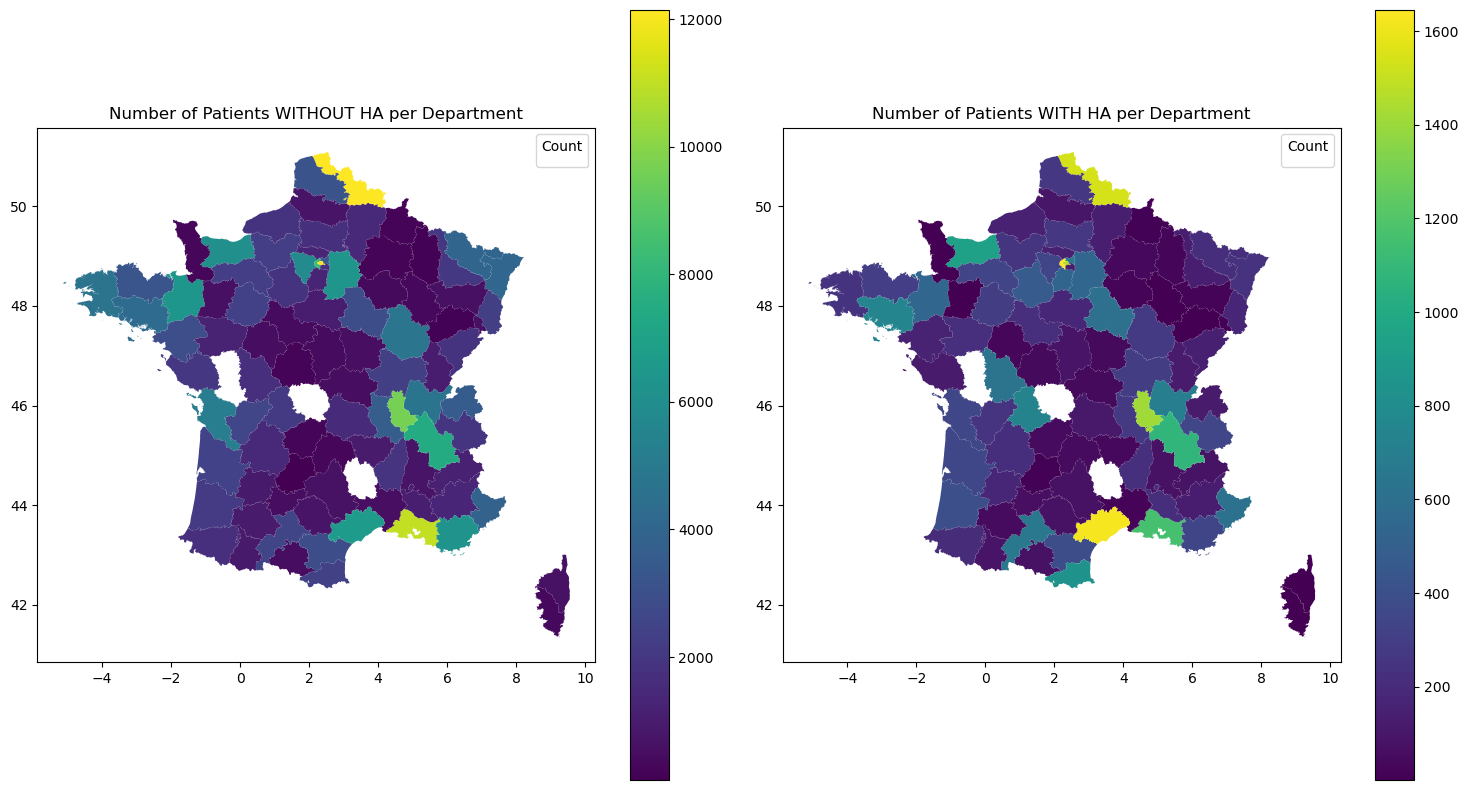

In [211]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the GeoDataFrame with color based on the count in the first subplot
map_france_ppapp_n.plot(column='Count', legend=True, ax=axs[0], cmap='viridis',
                         vmin=np.min(map_france_ppapp_n["Count"]),
                         vmax=np.max(map_france_ppapp_n["Count"]))
axs[0].set_title('Number of Patients WITHOUT HA per Department')
axs[0].legend(title='Count')

# Plot the GeoDataFrame with color based on the count in the second subplot
map_france_ppapp_y.plot(column='Count', legend=True, ax=axs[1], cmap='viridis', 
                        vmin=np.min(map_france_ppapp_y["Count"]),
                         vmax=np.max(map_france_ppapp_y["Count"]))
axs[1].set_title('Number of Patients WITH HA per Department')
axs[1].legend(title='Count')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [311]:
grouped_label_dp = df_Qs.groupby(['Label'])
unique_groups = list(grouped_label_dp.groups.keys())
split_label_dp = [grouped_label_dp.get_group(group) for group in unique_groups]

split_label_dp = [split_label_dp[i].drop_duplicates(subset='CUSTOMER_CODE', keep='first') for i in range(0,len(split_label_dp))]


mydept = split_label_dp[0]["Department"].unique()



# Iterate through split_label_dp and fill missing values in the 'Department' column
for i in range(len(split_label_dp)):
    missing_departments = set(mydept) - set(split_label_dp[i]['Department'].unique())
    
    if missing_departments:
        # Fill missing values with a default value (you can choose a different strategy)
        missing_rows = pd.DataFrame({'CUSTOMER_CODE': [np.nan] * len(missing_departments),
                                     'SEXE': [np.nan] * len(missing_departments),
                                     'AGE': [np.nan] * len(missing_departments),
                                     'SHOP_CODE': [np.nan] * len(missing_departments),
                                     'OPEN_ANSWER': [np.nan] * len(missing_departments),
                                     'APPAREILLE': [np.nan] * len(missing_departments),
                                     'Label': ['Conversation à 1 ou 2 dans le bruit'] * len(missing_departments),
                                     'Department': list(missing_departments)})
        split_label_dp[i] = pd.concat([split_label_dp[i], missing_rows]).reset_index(drop=True)




pp_counts_label = [ split_label_dp[i]['Department'].value_counts().reset_index() for i in range(0,len(split_label_dp))]

for i in range(0,len(pp_counts_label)):
    pp_counts_label[i].columns = ['nom', 'Count']



labels_plot = [split_label_dp[i]["Label"].unique()[0]  for i in range(0,len(split_label_dp))]


map_france_labels = [gdf_dpt_avec_om for i in range(0,len(split_label_dp))]
map_france_labels = [map_france_labels[i].merge(pp_counts_label[i], on='nom', how='inner') for i in range(0,len(split_label_dp))]


C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\627303448.py:26: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\627303448.py:26: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\627303448.py:26: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dty

In [434]:
# Define light green and dark green colors
light_green = '#B2DDFF'
dark_green = '#0072B2'

# Create LinearSegmentedColormap
cmap_labels = LinearSegmentedColormap.from_list('cmap_labels', [light_green, dark_green])

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\306358805.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



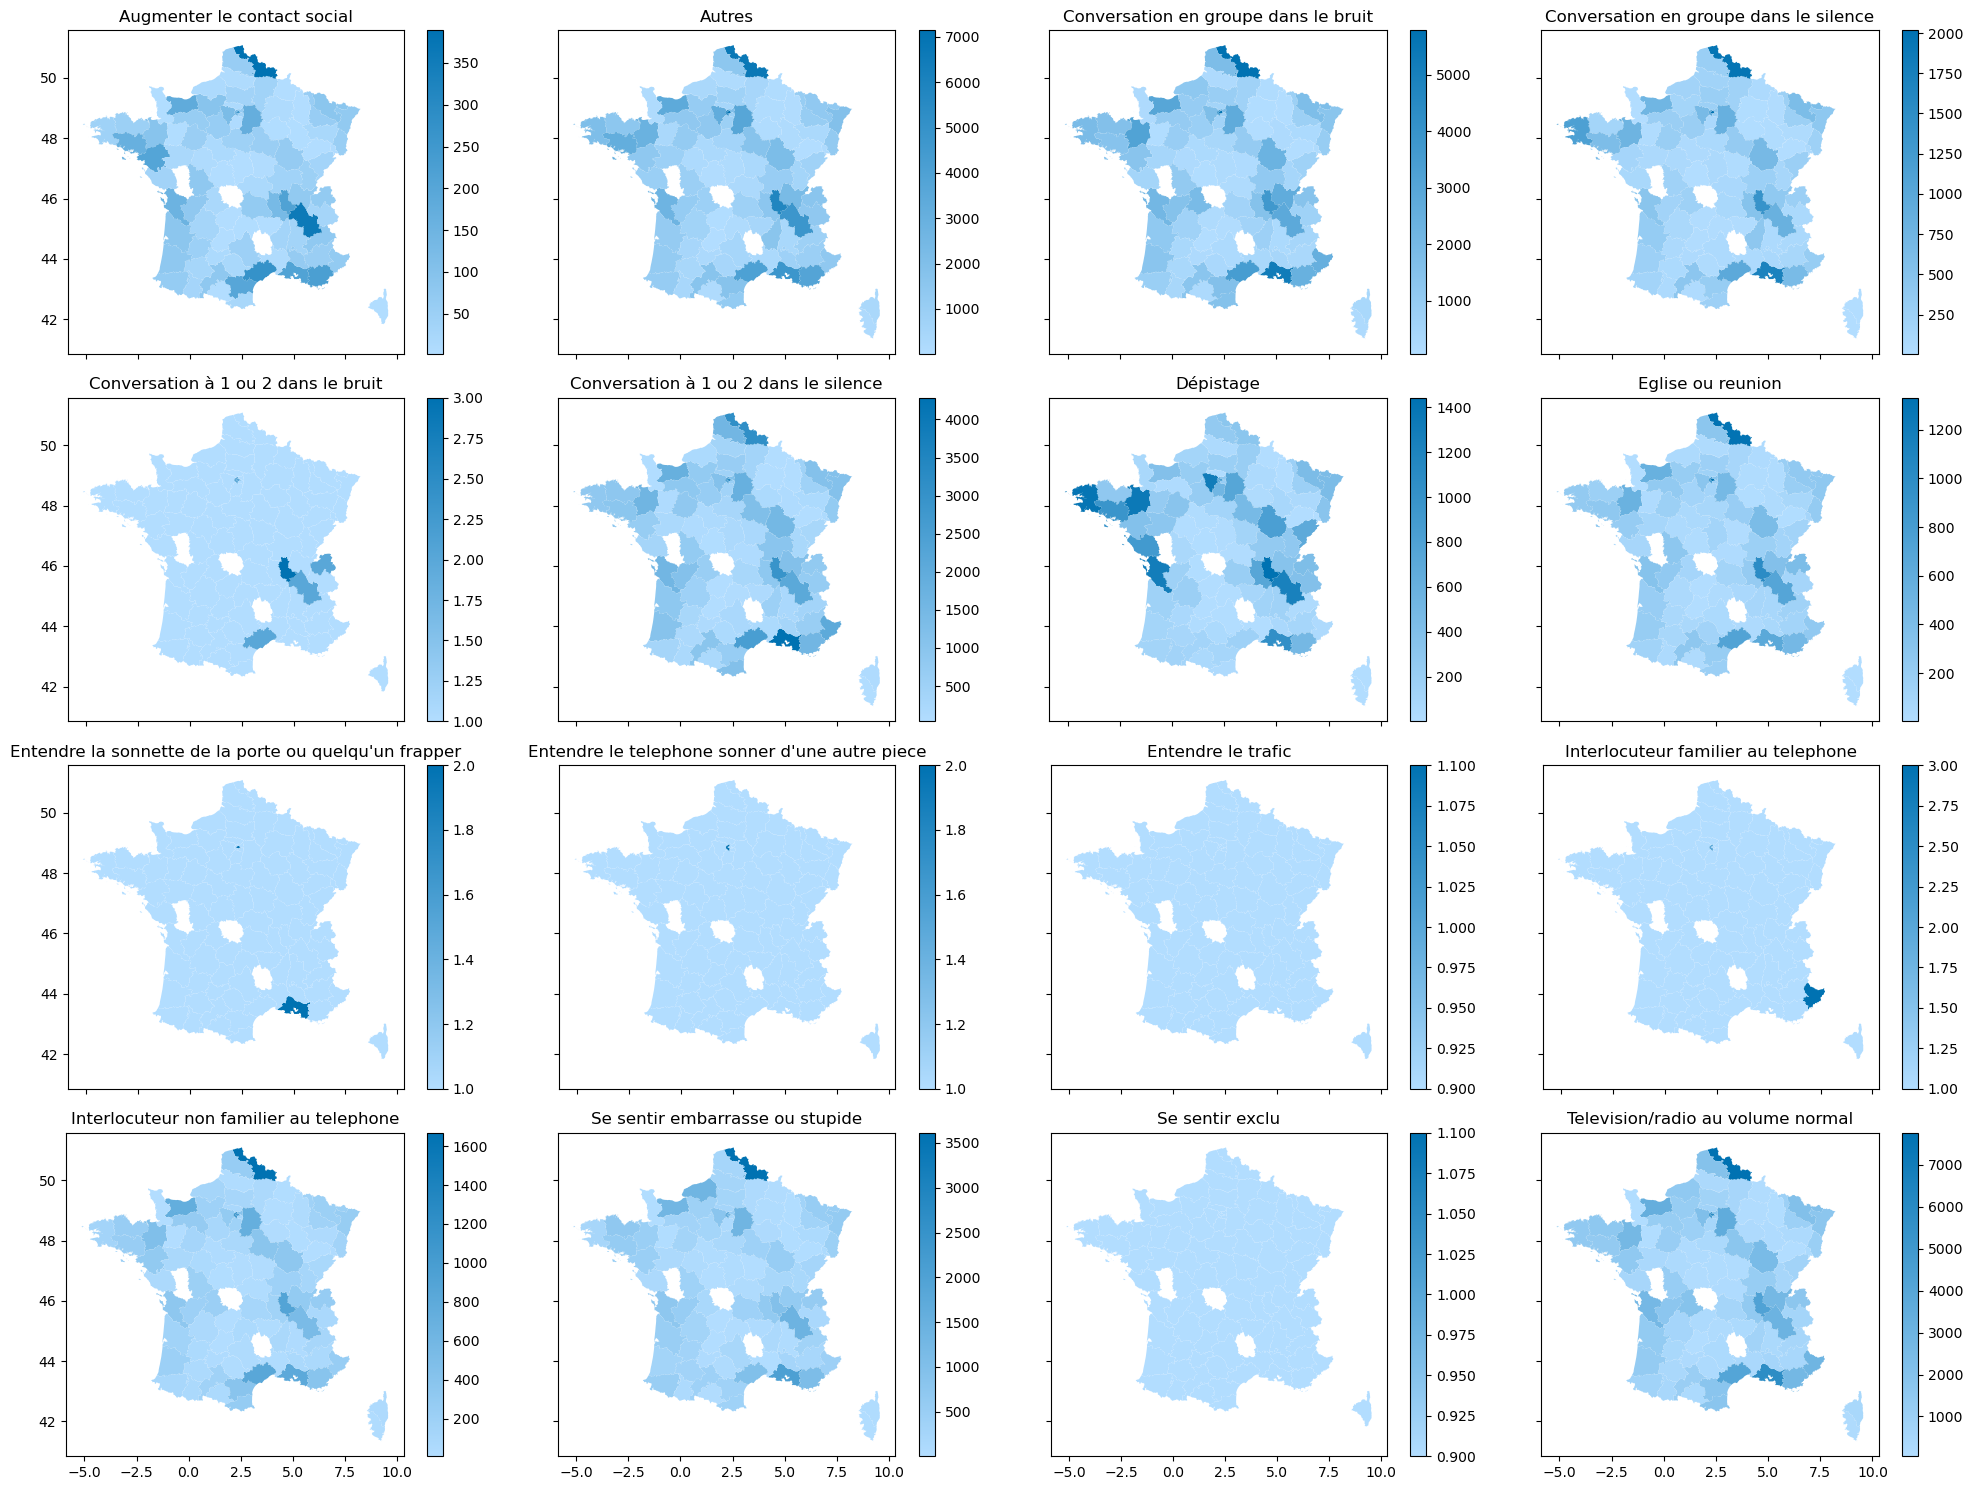

In [435]:
num_maps =  len(map_france_labels)
num_shades = 50  

# Create a list of 16 colormaps, each with varying shades
cmap_names = ['Blues', 'Reds', 'Greens', 'winter', 'Purples', 'Oranges', 'Greys', 'BuPu', 'RdYlBu', 'PuRd', 'YlOrBr', 'RdPu', 'YlOrRd', 'BuGn', 'YlGn', 'PuBu']
cmaps = [ListedColormap(plt.cm.get_cmap(name, num_shades)(np.linspace(0, 1, num_shades))) for name in cmap_names]

# Create subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex=True, sharey=True)
axs = axs.flatten()

for i, (gdf, label) in enumerate(zip(map_france_labels, labels_plot)):
    gdf.plot(column='Count', legend=True, cmap=cmap_labels#plt.cm.get_cmap("ocean"),   #cmaps[i], -- more work for this -- use ocean_r but fix it 
             ax=axs[i], vmin=np.min(map_france_labels[i]["Count"]),
               vmax=np.max(map_france_labels[i]["Count"]))
    axs[i].set_title(label)

plt.tight_layout()
plt.show()

In [419]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # Adjust the bin edges as needed
labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  # Generate labels for the bins

convbruit_age = split_label_dp[2]

# Create a new column 'AgeGroup' based on the bins
convbruit_age['AgeGroup'] = pd.cut(convbruit_age['AGE'], bins=bins, labels=labels_age, right=False)

# Now, you can group by the 'AgeGroup'
convbruit_df_agegr = convbruit_age.groupby('AgeGroup')

unique_groups = list(convbruit_df_agegr.groups.keys())
split_convbruit_age = [convbruit_df_agegr.get_group(group) for group in unique_groups]

# Iterate through split_label_dp and fill missing values in the 'Department' column
for i in range(len(split_convbruit_age)):
    missing_departments = set(mydept) - set(split_convbruit_age[i]['Department'].unique())
    
    if missing_departments:
        # Fill missing values with a default value (you can choose a different strategy)
        missing_rows = pd.DataFrame({'CUSTOMER_CODE': [np.nan] * len(missing_departments),
                                     'SEXE': [np.nan] * len(missing_departments),
                                     'AGE': [np.nan] * len(missing_departments),
                                     'SHOP_CODE': [np.nan] * len(missing_departments),
                                     'OPEN_ANSWER': [np.nan] * len(missing_departments),
                                     'APPAREILLE': [np.nan] * len(missing_departments),
                                     'Label': ['Conversation à 1 ou 2 dans le bruit'] * len(missing_departments),
                                     'Department': list(missing_departments)})
        split_convbruit_age[i] = pd.concat([split_convbruit_age[i], missing_rows]).reset_index(drop=True)

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\1259458288.py:29: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\1259458288.py:29: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\1259458288.py:29: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-

In [420]:
pp_counts_convbruitage = [ split_convbruit_age[i]['Department'].value_counts().reset_index() for i in range(0,len(split_convbruit_age))]

for i in range(0,len(pp_counts_convbruitage)):
    pp_counts_convbruitage[i].columns = ['nom', 'Count']


map_france_convbruitage = [gdf_dpt_avec_om for i in range(0,len(split_convbruit_age))]
map_france_convbruitage = [map_france_convbruitage[i].merge(pp_counts_convbruitage[i], on='nom', how='inner') for i in range(0,len(split_convbruit_age))]


In [440]:
# Define light green and dark green colors
light_green = '#B2DDFF'
dark_green = '#0072B2'

# Number of colors in the colormap
num_colors = 256

# Create a ListedColormap that transitions from light to dark green
cmap_bruit = ListedColormap([light_green, dark_green])


C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\2818465758.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



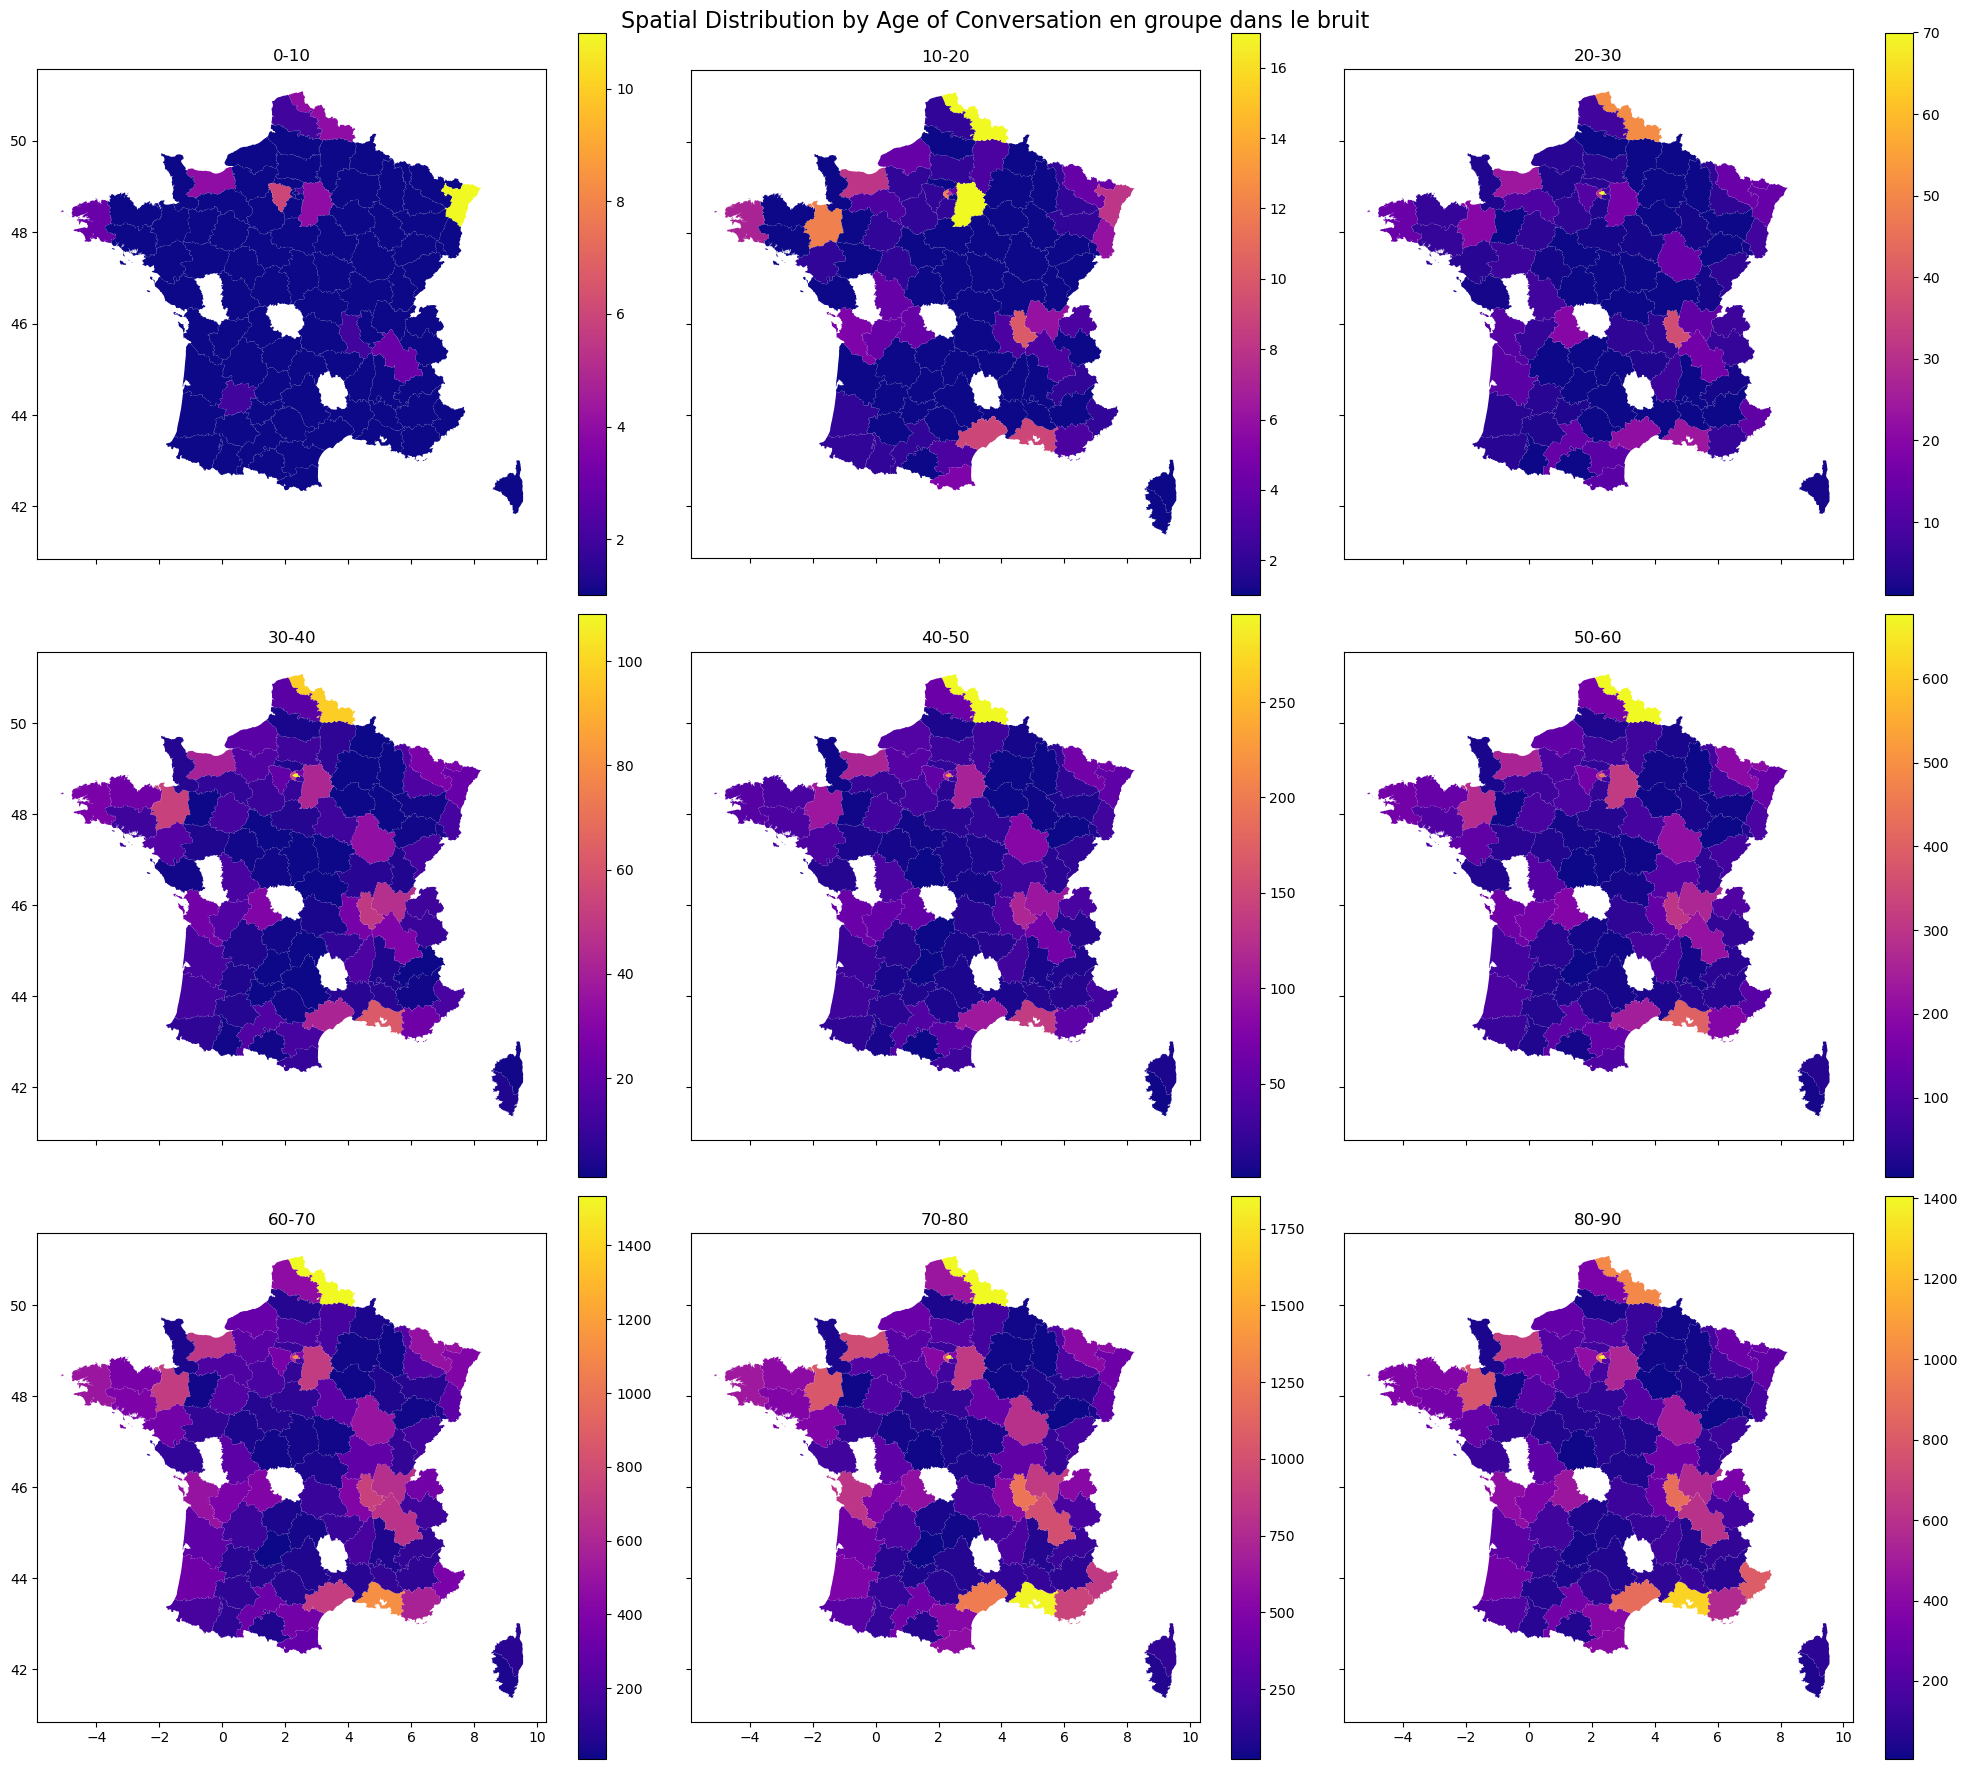

In [442]:
num_maps = len(map_france_convbruitage)
num_shades = 10
labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  # Generate labels for the bins


# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 18), sharex=True, sharey=True)
axs = axs.flatten()

# Ensure that you only iterate over the first 9 items
for i, (gdf, labels_age) in enumerate(zip(map_france_convbruitage[:9], labels_age[:9])):
    gdf.plot(column='Count', legend=True, cmap=plt.cm.get_cmap("plasma"),
              ax=axs[i])
    axs[i].set_title(labels_age)

# Remove any remaining empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('Spatial Distribution by Age of ' + labels_plot[2], fontsize=16)
plt.tight_layout()
plt.show()


In [411]:
#reset them 
labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  # Generate labels for the bins


In [426]:
labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  # Generate labels for the bins

convsil_age = split_label_dp[3]

# Create a new column 'AgeGroup' based on the bins
convsil_age['AgeGroup'] = pd.cut(convsil_age['AGE'], bins=bins, labels=labels_age, right=False)

# Now, you can group by the 'AgeGroup'
convsil_df_agegr = convsil_age.groupby('AgeGroup')

unique_groups = list(convsil_df_agegr.groups.keys())
split_convsil_age = [convsil_df_agegr.get_group(group) for group in unique_groups]

# Iterate through split_label_dp and fill missing values in the 'Department' column
for i in range(len(split_convsil_age)):
    missing_departments = set(mydept) - set(split_convsil_age[i]['Department'].unique())
    
    if missing_departments:
        # Fill missing values with a default value (you can choose a different strategy)
        missing_rows = pd.DataFrame({'CUSTOMER_CODE': [np.nan] * len(missing_departments),
                                     'SEXE': [np.nan] * len(missing_departments),
                                     'AGE': [np.nan] * len(missing_departments),
                                     'SHOP_CODE': [np.nan] * len(missing_departments),
                                     'OPEN_ANSWER': [np.nan] * len(missing_departments),
                                     'APPAREILLE': [np.nan] * len(missing_departments),
                                     'Label': ['Conversation à 1 ou 2 dans le bruit'] * len(missing_departments),
                                     'Department': list(missing_departments)})
        split_convsil_age[i] = pd.concat([split_convsil_age[i], missing_rows]).reset_index(drop=True)

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\1941044974.py:28: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\1941044974.py:28: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\1941044974.py:28: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-

C:\Users\mcampi\AppData\Local\Temp\ipykernel_15168\157540156.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



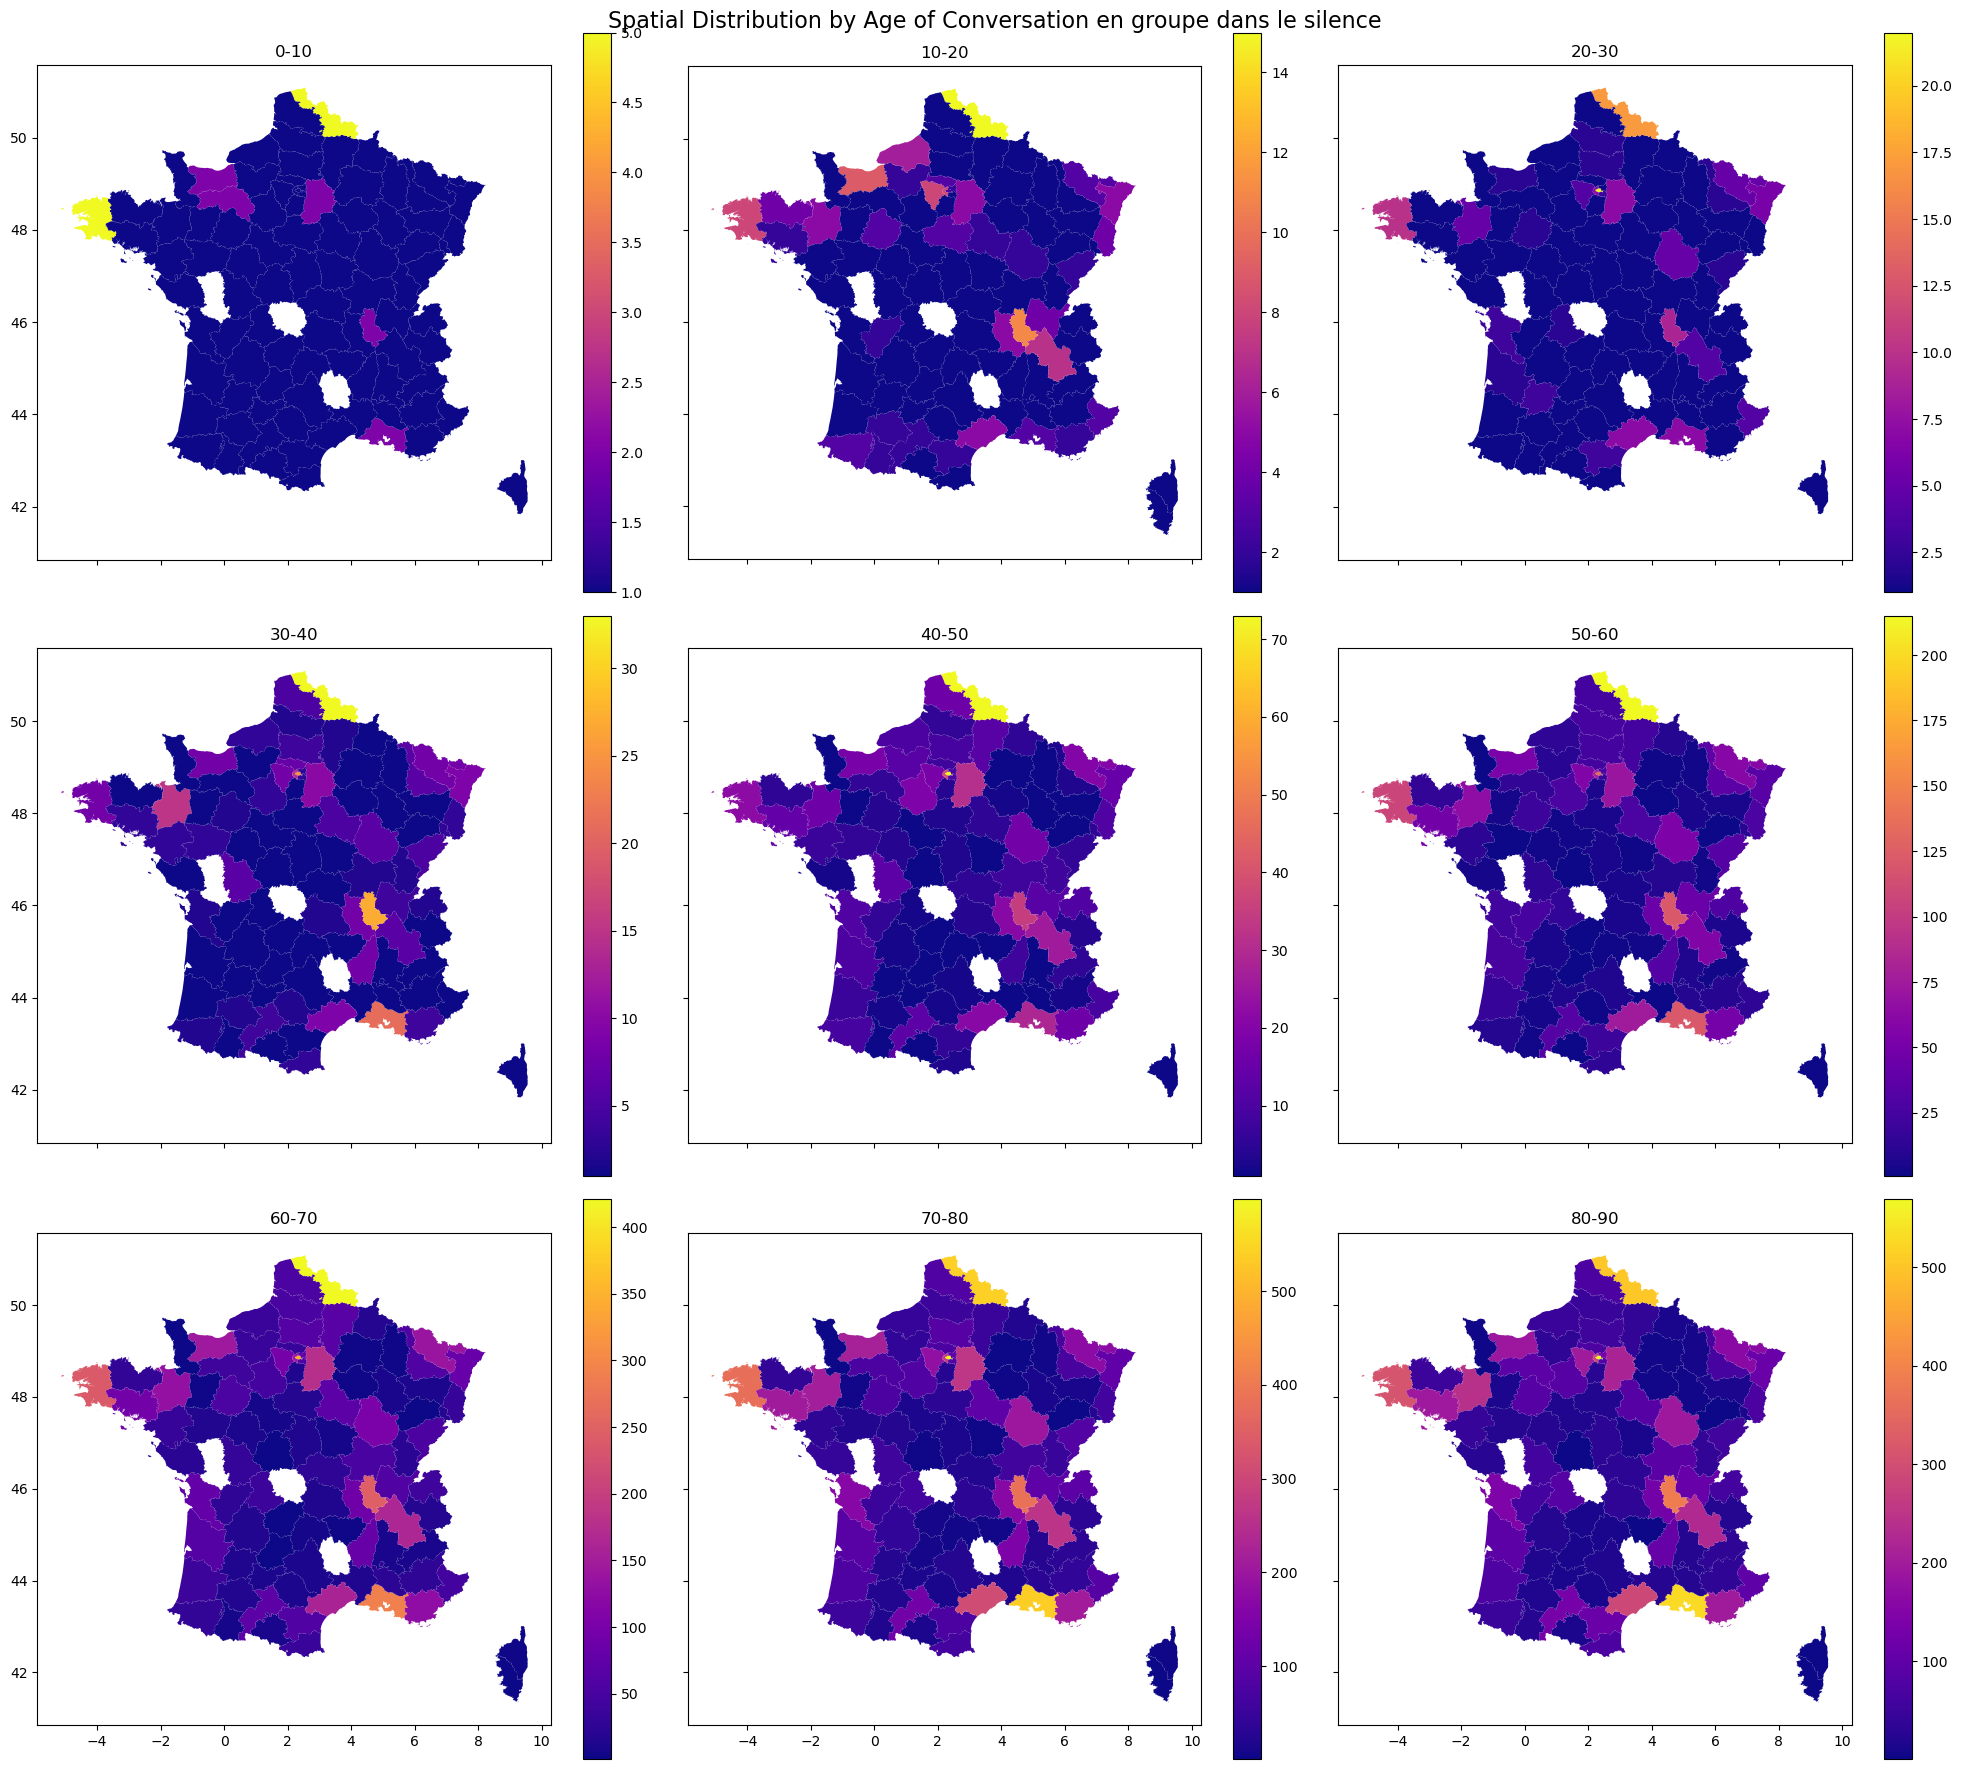

In [443]:
pp_counts_convsilage = [ split_convsil_age[i]['Department'].value_counts().reset_index() for i in range(0,len(split_convsil_age))]

for i in range(0,len(pp_counts_convsilage)):
    pp_counts_convsilage[i].columns = ['nom', 'Count']


map_france_convsilage = [gdf_dpt_avec_om for i in range(0,len(split_convsil_age))]
map_france_convsilage = [map_france_convsilage[i].merge(pp_counts_convsilage[i], on='nom', how='inner') for i in range(0,len(split_convsil_age))]

num_maps = len(map_france_convsilage)
num_shades = 10
labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  # Generate labels for the bins


# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 18), sharex=True, sharey=True)
axs = axs.flatten()

# Ensure that you only iterate over the first 9 items
for i, (gdf, labels_age) in enumerate(zip(map_france_convsilage[:9], labels_age[:9])):
    gdf.plot(column='Count', legend=True, cmap=plt.cm.get_cmap("plasma"), ax=axs[i])
    axs[i].set_title(labels_age)

# Remove any remaining empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('Spatial Distribution by Age of ' + labels_plot[3], fontsize=16)
plt.tight_layout()
plt.show()
